# Data Collection

### Riot - Data Dragon

In [1]:
import requests
import json
import os

# Data Dragon URL for latest version
VERSIONS_URL = "https://ddragon.leagueoflegends.com/api/versions.json"
BASE_URL = "https://ddragon.leagueoflegends.com/cdn"

# Get latest game version
def get_latest_version():
    res = requests.get(VERSIONS_URL)
    res.raise_for_status()
    versions = res.json()
    return versions[0]

# Load champion data (basic list + tags)
def get_champion_data(version):
    champ_list_url = f"{BASE_URL}/{version}/data/en_US/champion.json"
    res = requests.get(champ_list_url)
    res.raise_for_status()
    champions = res.json()["data"]
    return champions

# Get full details for each champion
def get_detailed_champion_data(version, champ_id):
    detail_url = f"{BASE_URL}/{version}/data/en_US/champion/{champ_id}.json"
    res = requests.get(detail_url)
    res.raise_for_status()
    return res.json()["data"][champ_id]

# Extract relevant text and save
def build_champion_text_dataset():
    version = get_latest_version()
    champions = get_champion_data(version)

    all_champions = []

    for champ_key in champions:
        champ_info = champions[champ_key]
        champ_id = champ_info["id"]
        tags = champ_info.get("tags", [])  # Riot role tags like 'Fighter', 'Support'
        detail = get_detailed_champion_data(version, champ_id)

        name = detail["name"]
        title = detail["title"]
        blurb = detail["blurb"]
        passive = detail["passive"]["description"]
        spells = [spell["description"] for spell in detail["spells"]]

        # Add roles/tags to full_text for better model context
        full_text = (
            f"{name}, {title}. {blurb} "
            f"Tags: {' '.join(tags)}. "
            f"Passive: {passive} " + " ".join([f"Spell: {s}" for s in spells])
        )

        all_champions.append({
            "name": name,
            "title": title,
            "blurb": blurb,
            "tags": tags,
            "passive": passive,
            "spells": spells,
            "full_text": full_text
        })

    # Save as JSON
    with open("riot_champion_data.json", "w", encoding="utf-8") as f:
        json.dump(all_champions, f, indent=2, ensure_ascii=False)

    print(f"Saved data for {len(all_champions)} champions.")

# Run it
build_champion_text_dataset()


Saved data for 170 champions.


### LoL Wiki

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re

def scrape_lol_wiki(champion_name):
    url_name = champion_name.replace(" ", "_")
    url = f"https://leagueoflegends.fandom.com/wiki/{url_name}"
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except Exception as e:
        print(f"Failed to fetch {champion_name}: {e}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Get title
    title_el = soup.find("h1", {"class": "page-header__title"})
    title = title_el.text.strip() if title_el else ""

    # Extract ability info
    ability_section = soup.find("span", {"id": "Abilities"})
    if ability_section:
        ability_texts = []
        for tag in ability_section.find_parent().find_next_siblings("p", limit=6):
            ability_texts.append(tag.get_text().strip())
        abilities = " ".join(ability_texts)
    else:
        abilities = ""

    return {
        "champion": champion_name,
        "title": title,
        "abilities": abilities
    }

def save_all_wiki_data_from_riot_json(riot_filename="riot_champion_data.json"):
    try:
        with open(riot_filename, "r", encoding="utf-8") as f:
            riot_data = json.load(f)
        champion_names = [entry["name"] for entry in riot_data]
    except Exception as e:
        print(f"Failed to load {riot_filename}: {e}")
        return

    all_data = []
    for i, name in enumerate(champion_names):
        data = scrape_lol_wiki(name)
        if data:
            all_data.append(data)
        else:
            print(f"Warning: Could not find positions for {name}")
        time.sleep(1.5) # To avoid rate limiting

    with open("wiki_champion_data.json", "w", encoding="utf-8") as f:
        json.dump(all_data, f, indent=2, ensure_ascii=False)
    print(f"\nSaved data for {len(all_data)} champions to wiki_champion_data.json.")

# Run the scraper
save_all_wiki_data_from_riot_json()

# Test print for Ahri
with open("wiki_champion_data.json", "r", encoding="utf-8") as f:
    wiki_data = json.load(f)
    for champion in wiki_data:
        if champion["champion"] == "Ahri":
            print(json.dumps(champion, indent=2, ensure_ascii=False))
            break



Saved data for 170 champions to wiki_champion_data.json.
{
  "champion": "Ahri",
  "title": "Ahri (Character)",
  "abilities": "Since childhood, Ahri has observed human civilization from afar until she encountered a hunter dying from a stray arrow. Curiously sensing his fading life force, Ahri got her first taste of spiritual essence and absorbed the man's memories, gaining all his knowledge and experiences. Since then, Ahri hunted down human prey for years, drunkenly drinking their essence and learning to manipulate them with her charms. She slowly felt a sense of regret as she grew empathetic from absorbing human emotions, eventually seeing how they perceived her as a monstrous fox demon. Despite this, Ahri accepted her monstrous nature and continued to feast on human essence. It wasn't until she met her first and only love, a human artist, that she began to feel true sympathy for humans and decided to completely Now, after befriending  Yasuo and the rest of  Sarah Fortune's crew, s

In [2]:
import json

#Champion positions dictionary 
champion_positions = {
    "Aatrox": ["Top"],
    "Ahri": ["Mid"],
    "Akali": ["Top", "Mid"],
    "Akshan": ["Mid"],
    "Alistar": ["Support"],
    "Ambessa": ["Top"],
    "Amumu": ["Jungle", "Support"],
    "Anivia": ["Mid"],
    "Annie": ["Mid"],
    "Aphelios": ["ADC"],
    "Ashe": ["ADC", "Support"],
    "Aurelion Sol": ["Mid"],
    "Aurora": ["Mid","Top"],
    "Azir": ["Mid"],
    "Bard": ["Support"],
    "Bel'Veth": ["Jungle"],
    "Blitzcrank": ["Support"],
    "Brand": ["Jungle", "Support", "Mid"],
    "Braum": ["Support"],
    "Briar": ["Jungle"],
    "Caitlyn": ["ADC"],
    "Camille": ["Top", "Support"],
    "Cassiopeia": ["Mid"],
    "Cho'Gath": ["Top"],
    "Corki": ["Mid"],
    "Darius": ["Top"],
    "Diana": ["Jungle", "Mid"],
    "Dr. Mundo": ["Top"],
    "Draven": ["ADC"],
    "Ekko": ["Jungle", "Mid"],
    "Elise": ["Jungle"],
    "Evelynn": ["Jungle"],
    "Ezreal": ["ADC"],
    "Fiddlesticks": ["Jungle"],
    "Fiora": ["Top"],
    "Fizz": ["Mid"],
    "Galio": ["Mid", "Support"],
    "Gangplank": ["Top"],
    "Garen": ["Top"],
    "Gnar": ["Top"],
    "Gragas": ["Jungle", "Top", "Mid"],
    "Graves": ["Jungle"],
    "Gwen": ["Top", "Jungle"],
    "Hecarim": ["Jungle"],
    "Heimerdinger": ["Support", "Top", "Mid"],
    "Hwei": ["Mid", "Support"],
    "Illaoi": ["Top"],
    "Irelia": ["Top", "Mid"],
    "Ivern": ["Jungle"],
    "Janna": ["Support"],
    "Jarvan IV": ["Jungle"],
    "Jax": ["Top", "Jungle"],
    "Jayce": ["Top", "Mid"],
    "Jhin": ["ADC"],
    "Jinx": ["ADC"],
    "K'Sante": ["Top"],
    "Kai'Sa": ["ADC"],
    "Kalista": ["ADC"],
    "Karma": ["Mid", "Support", "Top"],
    "Karthus": ["Jungle"],
    "Kassadin": ["Mid"],
    "Katarina": ["Mid"],
    "Kayle": ["Top"],
    "Kayn": ["Jungle"],
    "Kennen": ["Top"],
    "Kha'Zix": ["Jungle"],
    "Kindred": ["Jungle"],
    "Kled": ["Top"],
    "Kog'Maw": ["ADC"],
    "LeBlanc": ["Mid"],
    "Lee Sin": ["Jungle"],
    "Leona": ["Support"],
    "Lillia": ["Jungle"],
    "Lissandra": ["Mid"],
    "Lucian": ["ADC"],
    "Lulu": ["Support"],
    "Lux": ["Mid", "Support"],
    "Malphite": ["Top", "Mid", "Support"],
    "Malzahar": ["Mid"],
    "Maokai": ["Support", "Jungle"],
    "Master Yi": ["Jungle"],
    "Mel": ["Mid","Support"],
    "Milio": ["Support"],
    "Miss Fortune": ["ADC"],
    "Mordekaiser": ["Top"],
    "Morgana": ["Support"],
    "Naafiri": ["Mid"],
    "Nami": ["Support"],
    "Nasus": ["Top"],
    "Nautilus": ["Support"],
    "Neeko": ["Mid", "Support"],
    "Nidalee": ["Jungle"],
    "Nilah": ["ADC"],
    "Nocturne": ["Jungle"],
    "Nunu & Willump": ["Jungle"],
    "Olaf": ["Top"],
    "Orianna": ["Mid"],
    "Ornn": ["Top"],
    "Pantheon": ["Top", "Support", "Jungle", "Mid"],
    "Poppy": ["Top", "Jungle"],
    "Pyke": ["Support"],
    "Qiyana": ["Mid"],
    "Quinn": ["Top"],
    "Rakan": ["Support"],
    "Rammus": ["Jungle"],
    "Rek'Sai": ["Jungle"],
    "Rell": ["Support"],
    "Renata Glasc": ["Support"],
    "Renekton": ["Top"],
    "Rengar": ["Jungle", "Top"],
    "Riven": ["Top"],
    "Rumble": ["Top", "Mid"],
    "Ryze": ["Mid"],
    "Samira": ["ADC"],
    "Sejuani": ["Jungle"],
    "Senna": ["ADC", "Support"],
    "Seraphine": ["ADC", "Support"],
    "Sett": ["Top"],
    "Shaco": ["Jungle", "Support"],
    "Shen": ["Top", "Support"],
    "Shyvana": ["Jungle"],
    "Singed": ["Top"],
    "Sion": ["Top"],
    "Sivir": ["ADC"],
    "Skarner": ["Jungle", "Top"],
    "Smolder": ["ADC", "Top", "Mid"],
    "Sona": ["Support"],
    "Soraka": ["Support"],
    "Swain": ["Support", "Mid"],
    "Sylas": ["Mid", "Top"],
    "Syndra": ["Mid"],
    "Tahm Kench": ["Top", "Support"],
    "Taliyah": ["Jungle", "Mid"],
    "Talon": ["Mid", "Jungle"],
    "Taric": ["Support", "Mid"],
    "Teemo": ["Top", "Jungle", "Support"],
    "Thresh": ["Support"],
    "Tristana": ["ADC", "Mid"],
    "Trundle": ["Top", "Jungle"],
    "Tryndamere": ["Top"],
    "Twisted Fate": ["Mid", "ADC", "Top"],
    "Twitch": ["ADC", "Support"],
    "Udyr": ["Top", "Jungle"],
    "Urgot": ["Top"],
    "Varus": ["ADC"],
    "Vayne": ["ADC", "Top"],
    "Veigar": ["Mid", "Support"],
    "Vel'Koz": ["Support"],
    "Vex": ["Mid"],
    "Vi": ["Jungle"],
    "Viego": ["Jungle"],
    "Viktor": ["Mid"],
    "Vladimir": ["Mid", "Top"],
    "Volibear": ["Top", "Jungle"],
    "Warwick": ["Jungle", "Top"],
    "Wukong": ["Jungle", "Top"],
    "Xayah": ["ADC"],
    "Xerath": ["Mid", "Support"],
    "Xin Zhao": ["Jungle"],
    "Yasuo": ["Top", "Mid", "ADC"],
    "Yone": ["Top", "Mid"],
    "Yorick": ["Top"],
    "Yuumi": ["Support"],
    "Zac": ["Jungle", "Top", "Support"],
    "Zed": ["Mid", "Jungle"],
    "Zeri": ["ADC"],
    "Ziggs": ["ADC", "Mid"],
    "Zilean": ["Support"],
    "Zoe": ["Mid"],
    "Zyra": ["Support"]
}

#Load champion data
with open("wiki_champion_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Append positions to each champion
missing = []

for champ in data:
    name = champ["champion"]
    if name in champion_positions:
        champ["positions"] = champion_positions[name]
    else:
        champ["positions"] = []
        missing.append(name)

# Save to new file 
with open("wiki_champion_data_with_positions.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2, ensure_ascii=False)

# Print any unmatched names
if missing:
    print("Could not find positions for:")
    for name in missing:
        print("-", name)
else:
    print("All champions matched and saved.")


All champions matched and saved.


### Mobafire

In [38]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re

# Problematic Mobafire champion URL fixes
MOBALFIRE_NAME_FIXES = {
    "Aurelion Sol": "aurelion-sol-130",
    "Bel'Veth": "belveth",
    "Cho'Gath": "chogath",
    "Dr. Mundo": "dr-mundo-26",
    "Jarvan IV": "jarvan-iv-71",
    "Kai'Sa": "kaisa",
    "Kha'Zix": "khazix",
    "Kog'Maw": "kogmaw",
    "K'Sante": "ksante",
    "Lee Sin": "lee-sin-73",
    "Master Yi": "master-yi-3",
    "Miss Fortune": "miss-fortune-59",
    "Nunu & Willump": "nunu-amp-willump-12",
    "Rek'Sai": "reksai",
    "Renata Glasc": "renata-glasc-175",
    "Tahm Kench": "tahm-kench-126",
    "Twisted Fate": "twisted-fate-28",
    "Vel'Koz": "velkoz",
    "Xin Zhao": "xin-zhao-55",
    "Wukong": "wukong-80",
}

# Format fallback names and fix special characters
def format_mobafire_name(name):
    if name in MOBALFIRE_NAME_FIXES:
        return MOBALFIRE_NAME_FIXES[name]

    fallback = name.lower().replace(" ", "-")
    fallback = fallback.replace("'", "").replace(".", "").replace("&", "and")
    fallback = re.sub(r"[^\w\-]", "", fallback)
    return fallback

# Scrape a single champion's Mobafire guide description
def scrape_mobafire_description(champion_name):
    base_name = format_mobafire_name(champion_name)
    listing_url = f"https://www.mobafire.com/league-of-legends/champion/{base_name}"
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        listing_response = requests.get(listing_url, headers=headers)
        listing_response.raise_for_status()
    except Exception as e:
        print(f"Failed to fetch {champion_name} listing page: {e}")
        return {"champion": champion_name, "mobafire_description": "Error loading page"}

    listing_soup = BeautifulSoup(listing_response.text, "html.parser")

    guide_link_tag = listing_soup.find("a", class_="browse-list__guide-title")
    if not guide_link_tag or "href" not in guide_link_tag.attrs:
        return {"champion": champion_name, "mobafire_description": "No guide found"}

    guide_url = "https://www.mobafire.com" + guide_link_tag["href"]

    try:
        guide_response = requests.get(guide_url, headers=headers)
        guide_response.raise_for_status()
    except Exception as e:
        print(f"Failed to fetch guide for {champion_name}: {e}")
        return {"champion": champion_name, "mobafire_description": "Error loading guide"}

    guide_soup = BeautifulSoup(guide_response.text, "html.parser")

    content_div = guide_soup.find("div", class_="view-guide__full")
    if not content_div:
        return {"champion": champion_name, "mobafire_description": "No content found"}

    text = content_div.get_text(separator=" ", strip=True)
    return {
        "champion": champion_name,
        "mobafire_description": text[:1000]  # Limit to first 1000 chars
    }

# Load champion names and run the full scrape
def save_all_mobafire_data_from_riot_json(riot_filename="riot_champion_data.json"):
    try:
        with open(riot_filename, "r", encoding="utf-8") as f:
            riot_data = json.load(f)
        champion_names = [entry["name"] for entry in riot_data]
    except Exception as e:
        print(f"Failed to load {riot_filename}: {e}")
        return

    all_data = []
    for i, name in enumerate(champion_names):
        #print(f"Scraping Mobafire guide for {name} ({i+1}/{len(champion_names)})...")
        data = scrape_mobafire_description(name)
        all_data.append(data)
        time.sleep(2)  # Be kind to Mobafire servers

    with open("mobafire_champion_data.json", "w", encoding="utf-8") as f:
        json.dump(all_data, f, indent=2, ensure_ascii=False)

    print(f"\nSaved data for {len(all_data)} champions to mobafire_champion_data.json.")

# Run the scraper
if __name__ == '__main__':
    save_all_mobafire_data_from_riot_json()



Saved data for 170 champions to mobafire_champion_data.json.


### Merge 3 sources

In [55]:
import json

def load_json(filename):
    with open(filename, "r", encoding="utf-8") as f:
        return json.load(f)

# Load all sources
riot_data = load_json("riot_champion_data.json")
wiki_data = load_json("wiki_champion_data_with_positions.json")
mobafire_data = load_json("mobafire_champion_data.json")

# Convert wiki and mobafire to dicts for fast lookup
wiki_lookup = {entry["champion"]: entry for entry in wiki_data}
mobafire_lookup = {entry["champion"]: entry for entry in mobafire_data}

# Merge data
compiled = []

for entry in riot_data:
    name = entry["name"]
    riot_text = entry.get("full_text", "")
    riot_tags = entry.get("tags", [])  # from Riot data, e.g. ['Fighter', 'Tank']
    wiki_text = wiki_lookup.get(name, {}).get("abilities", "")
    positions = wiki_lookup.get(name, {}).get("positions", [])
    mobafire_text = mobafire_lookup.get(name, {}).get("mobafire_description", "")

    combined_text = f"{riot_text}\n\nWIKI:\n{wiki_text}\n\nMOBAFIRE:\n{mobafire_text}"

    compiled.append({
        "champion": name,
        "tags": riot_tags,
        "positions": positions,
        "combined_text": combined_text
    })

# Save the final compiled profile
with open("compiled_champion_profiles.json", "w", encoding="utf-8") as f:
    json.dump(compiled, f, indent=2, ensure_ascii=False)

print(f"✅ Saved {len(compiled)} champions to compiled_champion_profiles.json.")


✅ Saved 170 champions to compiled_champion_profiles.json.


# Data Cleaning and Preprocessing

In [3]:
import re
import json
from sentence_transformers import SentenceTransformer  # Only needed later if you're embedding

# Load raw compiled data
with open("compiled_champion_profiles.json", "r", encoding="utf-8") as f:
    champion_data = json.load(f)

# Text cleaning function
def clean_combined_text(text):
    text = text.lower().strip()
    text = re.sub(r'<[^>]+>', '', text)               # Remove HTML-like tags
    text = re.sub(r"\\n|\\", " ", text)               # Replace escaped newlines
    text = re.sub(r"[^a-zA-Z\s]", "", text)           # Remove non-letter characters
    text = re.sub(r"\s+", " ", text)                  # Collapse multiple spaces
    return text

# Process and store cleaned data 
cleaned_data = []

for entry in champion_data:
    cleaned_text = clean_combined_text(entry["combined_text"])
    cleaned_data.append({
        "champion": entry["champion"],
        "tags": entry.get("tags", []),
        "positions": entry.get("positions", []),
        "cleaned_text": cleaned_text
    })

# Save the cleaned output
with open("cleaned_champion_profiles.json", "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, indent=2, ensure_ascii=False)

print(f"Saved cleaned data for {len(cleaned_data)} champions to cleaned_champion_profiles.json.")


C:\Users\hisie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved cleaned data for 170 champions to cleaned_champion_profiles.json.


In [1]:
import json
from sentence_transformers import SentenceTransformer

# Load cleaned data
with open("cleaned_champion_profiles.json", "r", encoding="utf-8") as f:
    cleaned_data = json.load(f)

champions = []
texts = []
champion_positions_list = []  # <-- new list for position filtering

for entry in cleaned_data:
    if entry["cleaned_text"]:
        champions.append(entry["champion"])
        
        # Build prefix with roles and tags
        roles = " ".join(entry.get("positions", []))
        tags = " ".join(entry.get("tags", []))
        prefix = f"{roles} {tags}"
        
        # Combine into embedding text
        full_text = f"{prefix}. {entry['cleaned_text']}"
        texts.append(full_text)

        # Store position list for each champion (used in filtering)
        champion_positions_list.append(entry.get("positions", []))

# Generate SBERT embeddings
SBERT_model = SentenceTransformer('all-MiniLM-L6-v2')
combined_text_embeddings = SBERT_model.encode(texts, convert_to_tensor=True)

print("SBERT embeddings generated with tags and positions included.")


C:\Users\kenzi\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SBERT embeddings generated with tags and positions included.


In [2]:
# checking the champions and texts aren't none
print("champions: ", champions)
print("texts: ", texts)

champions:  ['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Ambessa', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'Aurelion Sol', 'Aurora', 'Azir', 'Bard', "Bel'Veth", 'Blitzcrank', 'Brand', 'Braum', 'Briar', 'Caitlyn', 'Camille', 'Cassiopeia', "Cho'Gath", 'Corki', 'Darius', 'Diana', 'Draven', 'Dr. Mundo', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'Fiddlesticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Hecarim', 'Heimerdinger', 'Hwei', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'Jarvan IV', 'Jax', 'Jayce', 'Jhin', 'Jinx', "Kai'Sa", 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', "Kha'Zix", 'Kindred', 'Kled', "Kog'Maw", "K'Sante", 'LeBlanc', 'Lee Sin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'Master Yi', 'Mel', 'Milio', 'Miss Fortune', 'Wukong', 'Mordekaiser', 'Morgana', 'Naafiri', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nilah', 'Nocturne', 'Nunu & Wil

### Clean and Embed User Inputs

In [3]:
# Function for cleaning AND embedding the user input
def clean_and_embed_user_input(user_input, model):
    # Lowercase and strip
    text = user_input.lower().strip()
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    # Remove html-like tags
    text = re.sub(r'<[^>]+>', '', text)
    # Replace escaped newlines
    text = re.sub(r'\\n|\\', ' ', text)
    # Collapse whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return model.encode(text, convert_to_tensor=True)

# Main Function: Reccomend Champions

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Recommend champions based on playstyle + position
def recommend_champions(user_input, position_filter, model, champion_embeddings, champion_names, champion_positions, top_k=5):
    print(f"\nUser Input: {user_input}")
    print(f"Preferred Position: {position_filter}")

    # Filter champions based on preferred position
    filtered_indices = [
        i for i, pos_list in enumerate(champion_positions)
        if any(position_filter.lower() == p.lower() for p in pos_list)
    ]

    if not filtered_indices:
        print("No champions found for that position. Please try again.")
        return []

    # Filter embeddings and names
    filtered_embeddings = champion_embeddings[filtered_indices]
    filtered_names = [champion_names[i] for i in filtered_indices]

    # Embed and clean user input
    user_embedding = clean_and_embed_user_input(user_input, model).cpu().numpy().reshape(1, -1)
    filtered_embeddings = filtered_embeddings.cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(user_embedding, filtered_embeddings)[0]
    top_k_indices = similarities.argsort()[-top_k:][::-1]

    # Display recommendations
    print("\nTop Champion Recommendations:")
    top_k_champions = []
    for i in top_k_indices:
        champ_name = filtered_names[i]
        similarity = float(similarities[i])
        print(f"{champ_name} (Similarity: {similarity:.4f})")
        top_k_champions.append((champ_name, similarity))

    return top_k_champions


## Test: Playstyle Input Prompt

From here we need to add an optional filter, I haven't figured it out yet but looks like its working better so far. I embedded the positions and tags and it has worked better but still getting non-support champs when asking for a support because of overlapping verbage.

In [8]:
import re

# Prompt user for playstyle and position
user_input = input("Enter your playstyle description: ")
position_input = input("Enter your preferred position (Top, Jungle, Mid, ADC, Support): ")

# Run the recommendation function
recommended_champions = recommend_champions(
    user_input,
    position_input,
    SBERT_model,
    combined_text_embeddings,
    champions,
    champion_positions_list,  # <- must match
    top_k=5
)



User Input: i love any champ
Preferred Position: ADC

Top Champion Recommendations:
Kalista (Similarity: 0.3212)
Nilah (Similarity: 0.3078)
Yasuo (Similarity: 0.2885)
Draven (Similarity: 0.2805)
Smolder (Similarity: 0.2694)


# Experiment 1

### Test Prompts with Ground Truth Champions

In [9]:
test_prompts = [
    {
        "prompt": "I'm looking for a durable tank who can start fights and absorb lots of damage.",
        "position": "Support",
        "ground_truth": ["Leona", "Nautilus", "Rell", "Alistar", "Amumu", "Zac", "Maokai", "Taric", "Shen", "Braum"]
    },
    {
        "prompt": "I want a long-range mage who can poke enemies from a safe distance.",
        "position": "Mid",
        "ground_truth": ["Xerath", "Ziggs", "Lux", "Hwei", "Zoe", "Syndra", "Viktor", "Cassiopeia", "Swain", "Lissandra"]
    },
    {
        "prompt": "I prefer stealthy assassins who can sneak in and delete backline carries.",
        "position": "Jungle",
        "ground_truth": ["Evelynn", "Kha'Zix", "Shaco", "Rengar", "Nocturne", "Talon", "Qiyana", "Ekko", "Elise", "Zed"]
    },
    {
        "prompt": "I want a supportive enchanter who can shield, heal, or buff teammates.",
        "position": "Support",
        "ground_truth": ["Soraka", "Janna", "Nami", "Lulu", "Yuumi", "Karma", "Sona", "Milio", "Renata Glasc", "Zilean"]
    },
    {
        "prompt": "I'm looking for a high-mobility ADC with strong burst or sustained damage.",
        "position": "ADC",
        "ground_truth": ["Lucian", "Ezreal", "Kai'Sa", "Vayne", "Tristana", "Samira", "Nilah", "Kalista", "Zeri", "Jinx"]
    },
    {
        "prompt": "I like playing control mages who can zone enemies and scale into late game teamfights.",
        "position": "Mid",
        "ground_truth": ["Orianna", "Anivia", "Viktor", "Azir", "Cassiopeia", "Veigar", "Syndra", "Taliyah", "Swain", "Lissandra"]
    },
    {
        "prompt": "I enjoy tanky melee bruisers who can sustain through extended fights.",
        "position": "Top",
        "ground_truth": ["Aatrox", "Illaoi", "Sett", "Trundle", "Garen", "Darius", "Mordekaiser", "Yorick", "Renekton", "Volibear"]
    },
    {
        "prompt": "I'm looking for a jungler who clears camps quickly and excels at ganking.",
        "position": "Jungle",
        "ground_truth": ["Hecarim", "Vi", "Lillia", "Nidalee", "Graves", "Elise", "Jarvan IV", "Lee Sin", "Nocturne", "Olaf"]
    },
    {
        "prompt": "I like duelists who are great at split-pushing and taking 1v1s.",
        "position": "Top",
        "ground_truth": ["Tryndamere", "Jax", "Fiora", "Yorick", "Camille", "Nasus", "Riven", "Kled", "Irelia", "Renekton"]
    },
    {
        "prompt": "I enjoy high-damage champions who can combo and one-shot squishy targets.",
        "position": "Mid",
        "ground_truth": ["Zed", "LeBlanc", "Katarina", "Fizz", "Akali", "Qiyana", "Talon", "Syndra", "Ahri", "Vex"]
    },
    {
        "prompt": "I'm looking for a support that can roam the map and make proactive plays.",
        "position": "Support",
        "ground_truth": ["Thresh", "Pyke", "Nautilus", "Bard", "Rakan", "Alistar", "Blitzcrank", "Pantheon", "Leona", "Galio"]
    },
    {
        "prompt": "I want a tanky top laner who becomes unkillable in teamfights.",
        "position": "Top",
        "ground_truth": ["Sion", "Dr. Mundo", "Poppy", "Maokai", "Ornn", "Malphite", "Shen", "Cho'Gath", "Gragas", "Tahm Kench"]
    },
    {
        "prompt": "I'm interested in artillery mages who can keep enemies at a distance.",
        "position": "Mid",
        "ground_truth": ["Xerath", "Ziggs", "Vel'Koz", "Lux", "Hwei", "Zoe", "Heimerdinger", "Jayce", "Varus", "Taliyah"]
    },
    {
        "prompt": "I like fast-paced assassins who roam the map and snowball through kills.",
        "position": "Jungle",
        "ground_truth": ["Evelynn", "Kha'Zix", "Talon", "Qiyana", "Shaco", "Zed", "Pantheon", "Ekko", "Nocturne", "Nidalee"]
    },
    {
        "prompt": "I'm looking for a marksman who pairs well with crowd control-heavy teams.",
        "position": "ADC",
        "ground_truth": ["Jhin", "Ashe", "Miss Fortune", "Varus", "Caitlyn", "Aphelios", "Ezreal", "Senna", "Kog'Maw", "Smolder"]
    }
]


### Evaluation Function

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def run_experiment_1(prompts, model, champion_embeddings, champion_names, champion_positions, top_k=10):
    correct_count = 0
    reciprocal_ranks = []
    positions = []
    found_match = []
    all_reciprocal_ranks = []
    prompt_num = []
    reccomended_champs = []

    for i, entry in enumerate(prompts):
        print(f"\nPrompt {i+1}: {entry['prompt']}")
        ground_truth = [name.lower() for name in entry["ground_truth"]]
        position_filter = entry.get("position", None)

        # Get model predictions (with position filtering)
        predictions = recommend_champions(
            user_input=entry["prompt"],
            position_filter=position_filter,
            model=model,
            champion_embeddings=champion_embeddings,
            champion_names=champion_names,
            champion_positions=champion_positions,
            top_k=top_k
        )

        reccomended_champs.append(predictions)

        predicted_names = [name.lower() for name, _ in predictions]

        # Top-k accuracy
        match_found = any(gt in predicted_names for gt in ground_truth)
        if match_found:
            correct_count += 1

        # MRR calculation
        ranks = [predicted_names.index(gt) + 1 for gt in ground_truth if gt in predicted_names]
        reciprocal_ranks.append(1 / min(ranks) if ranks else 0)

        # save values for visualizations
        positions.append(position_filter)
        found_match.append(match_found)
        all_reciprocal_ranks.append(reciprocal_ranks[-1])
        prompt_num.append(i + 1)

        print(f"Position: {position_filter}")
        print(f"Ground truth champions: {entry['ground_truth']}")
        print(f"Top-{top_k} Match Found: {'✅ Yes' if match_found else '❌ No'}")
        print(f"Reciprocal Rank: {reciprocal_ranks[-1]:.4f}")

    # Final metrics
    top_k_accuracy = correct_count / len(prompts)
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)

    print("\nFinal Evaluation Metrics")
    print(f"Top-{top_k} Accuracy: {top_k_accuracy:.2f}")
    print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")

    return top_k_accuracy, mrr, positions, found_match, all_reciprocal_ranks, prompt_num, reccomended_champs


### Run the Experiment

if we change this to 10, we get a much higher Top-10 Accuracy but Mean Reciprocal Rank (MRR) is still low which I don't think is that much of an issue? idk like as long as one of the 10 is in the ground truths I would think that would be good? for this specific type of game where so many characters do work for the same playstyles 

In [78]:
import re

top_k_accuracy, mrr, positions, found_match, all_reciprocal_ranks, prompt_num, recommend_champs = run_experiment_1(
    prompts=test_prompts,
    model=SBERT_model,
    champion_embeddings=combined_text_embeddings,
    champion_names=champions,
    champion_positions=[entry["positions"] for entry in cleaned_data],
    top_k=10
)


Prompt 1: I'm looking for a durable tank who can start fights and absorb lots of damage.

User Input: I'm looking for a durable tank who can start fights and absorb lots of damage.
Preferred Position: Support

Top Champion Recommendations:
Nautilus (Similarity: 0.4052)
Alistar (Similarity: 0.3870)
Galio (Similarity: 0.3851)
Braum (Similarity: 0.3729)
Blitzcrank (Similarity: 0.3644)
Zac (Similarity: 0.3541)
Maokai (Similarity: 0.3444)
Tahm Kench (Similarity: 0.3434)
Teemo (Similarity: 0.3386)
Rell (Similarity: 0.3377)
Position: Support
Ground truth champions: ['Leona', 'Nautilus', 'Rell', 'Alistar', 'Amumu', 'Zac', 'Maokai', 'Taric', 'Shen', 'Braum']
Top-10 Match Found: ✅ Yes
Reciprocal Rank: 1.0000

Prompt 2: I want a long-range mage who can poke enemies from a safe distance.

User Input: I want a long-range mage who can poke enemies from a safe distance.
Preferred Position: Mid

Top Champion Recommendations:
Heimerdinger (Similarity: 0.4215)
Ziggs (Similarity: 0.4148)
Sylas (Similari

### Visualize Results

In [79]:
# create dataframe with all results for visualization
import pandas as pd

# take top similarity champion names from recommendations
top_similarities = []
for rec in recommend_champs:
    # grab highest similarity score
    top_similarities.append(max(rec, key=lambda x: x[1]))

print(top_similarities)

# add prompt number, position, match found, reciprocal rank, and reccomended champs name + similarity to results df
ex1_results = pd.DataFrame({
    "Prompt": prompt_num,
    "Position": positions,
    "Match Found": found_match,
    "Reciprocal Rank": all_reciprocal_ranks,
    "Top Similarity": (sim[1] for sim in top_similarities)
})

print("Experiment 1 Results: ", ex1_results)

[('Nautilus', 0.4052141606807709), ('Heimerdinger', 0.42151516675949097), ('Kayn', 0.4043734669685364), ('Lulu', 0.5287290215492249), ('Sivir', 0.4122317135334015), ('Vladimir', 0.38826441764831543), ('Gnar', 0.43115469813346863), ('Teemo', 0.47180476784706116), ('Fiora', 0.4307742714881897), ('Jayce', 0.39783623814582825), ('Teemo', 0.3254454433917999), ('Warwick', 0.5448380708694458), ('Ziggs', 0.3896839916706085), ('Graves', 0.40916523337364197), ('Caitlyn', 0.32384833693504333)]
Experiment 1 Results:      Prompt Position  Match Found  Reciprocal Rank  Top Similarity
0        1  Support         True         1.000000        0.405214
1        2      Mid         True         0.500000        0.421515
2        3   Jungle         True         0.500000        0.404373
3        4  Support         True         1.000000        0.528729
4        5      ADC         True         0.500000        0.412232
5        6      Mid         True         0.142857        0.388264
6        7      Top        

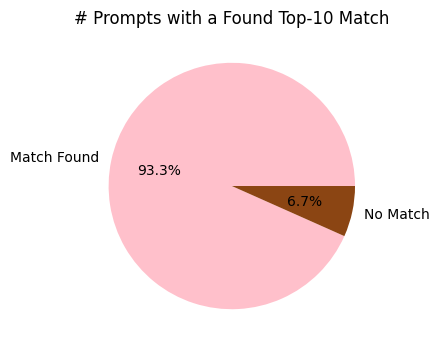

In [49]:
# Pie Chart for how many found ground truth champions
# create list of matches

import matplotlib.pyplot as plt

# count number of matches and number with no matches
num_matches = sum(found_match)
num_no_matches = len(found_match) - num_matches
# create labels for the sections of the pie chart
match_labels = ['Match Found', 'No Match']
# use the counts to create the sizes for each section
match_sizes = [num_matches, num_no_matches]
# customize the colors
colors = ['pink', 'saddlebrown']

# plot the pie chart
plt.figure(figsize=(4,4))
plt.pie(match_sizes, labels=match_labels, autopct='%1.1f%%', colors=colors)
plt.title('# Prompts with a Found Top-10 Match')
plt.show()

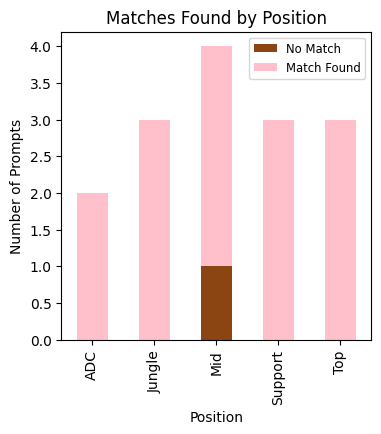

In [77]:
# Bar Chart for Match Found by Position
import pandas as pd
import matplotlib.pyplot as plt

# calculate how many matches were found for each position
position_matches = ex1_results.groupby(['Position','Match Found']).size().unstack(fill_value=0)

# plot the grouped values on a bar chart
position_matches.plot(kind='bar', stacked=True, figsize=(4,4), color={False: 'saddlebrown', True: 'pink'})
# change the title and axes labels
plt.title('Matches Found by Position')
plt.xlabel('Position')
plt.ylabel('Number of Prompts')

# label as match found or not
plt.legend(['No Match', 'Match Found'], loc='upper right',fontsize='small')
plt.show()

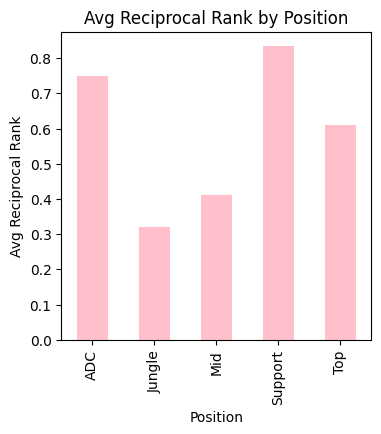

In [51]:
# Bar Chart for reciprocal rank by position
import pandas as pd
import matplotlib.pyplot as plt

# calculate how many matches were found for each position
position_matches = ex1_results.groupby('Position')['Reciprocal Rank'].mean()

# plot the grouped values on a bar chart
position_matches.plot(kind='bar', stacked=True, figsize=(4,4), color='pink')
# change the title and axes labels
plt.title('Avg Reciprocal Rank by Position')
plt.xlabel('Position')
plt.ylabel('Avg Reciprocal Rank')
plt.show()

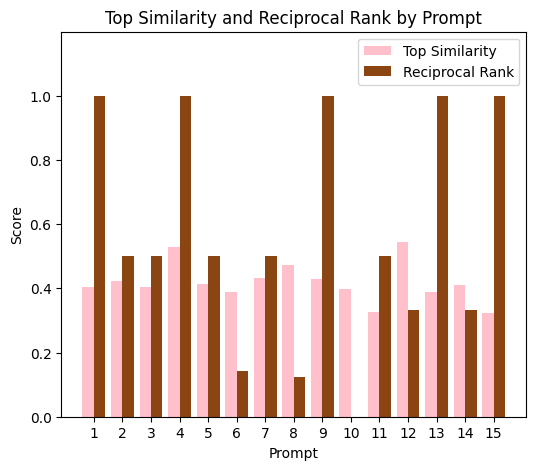

In [73]:
# bar chart showing top similarity and reciprocal rank by prompt

# set up bar chart 
labels = np.arange(len(ex1_results))
width = 0.4
fig, ax = plt.subplots(figsize=(6,5))

sim_bars = ax.bar(labels - width/2, ex1_results['Top Similarity'], width, label='Top Similarity', color='pink')
reciprocal_bars = ax.bar(labels + width/2, ex1_results['Reciprocal Rank'], width, label='Reciprocal Rank', color='saddlebrown')

ax.set_xlabel('Prompt')
ax.set_ylabel('Score')
ax.set_title('Top Similarity and Reciprocal Rank by Prompt')
ax.legend(loc ='upper right')
ax.set_xticks(labels)
ax.set_xticklabels(range(1, len(ex1_results)+1))
ax.set_ylim(0, 1.2)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()



# Experiment 2

### User Inputs

In [5]:
# List of user prompts and their preferred positions
experiment2_users = [
    {"user": "USER 1", "prompt": "I want a jungler who is tanky and has a lot of crowd control.", "position": "Jungle"},
    {"user": "USER 2", "prompt": "I want a tanky melee character with some area of effect attacks.", "position": "Top"},
    {"user": "USER 3", "prompt": "I'm looking for a support mage with healing, shielding, and hastening abilities. I’d like them to have a good range and be able to slow, enchant, or root enemies to support crowd control in the late game.", "position": "Support"},
    {"user": "USER 4", "prompt": "My ideal play style in league is to be able to deal massive amounts of damage really quickly in order to be able to eliminate enemies and destroy objectives quickly. I like to play characters that require high skill to be able to land abilities with high chance of failure but high reward.", "position": "ADC"},
    {"user": "USER 5", "prompt": "I like to play top lane champions that can survive on their own and carry the game without any help from teammates.", "position": "Top"},
    {"user": "USER 6", "prompt": "My ideal play style would be someone with stun and rooting capabilities. I want a ranged character who is easy to learn.", "position": "Support"},
    {"user": "USER 7", "prompt": "I want to play a burst champion that can poke down enemies from a distance and has quick engage and disengage.", "position": "Mid"},
    {"user": "USER 8", "prompt": "I like reliable ADCs that can poke down enemies from a safe distance and don’t require any complicated movements.", "position": "ADC"},
    {"user": "USER 9", "prompt": "Being able to help all lanes while also having fun killing people.", "position": "Jungle"},
    {"user": "USER 10", "prompt": "My ideal champion playstyle is being able to put enemy players in bad positions and impact team fights with good timing", "position": "Support"},
    {"user": "USER 11", "prompt": "I want a tanky fighter that snowballs well into late game", "position": "Top"},
    {"user": "USER 12", "prompt": "I’d like a nimble character who’s fast. I’d like the controls to be simple and for the champion to have good crowd control.", "position": "ADC"},
    {"user": "USER 13", "prompt": "My ideal league playstyle is to slowly choke out my opponent - meaning no flashy plays just consistently getting more farm and building up.", "position": "ADC"},
]




### Recommendations

In [6]:
import re

positions2 = []
prompt_num2 = []
curr_promt = 0
reccomended_champs2 = []

# Run recommendations for all users
for user_entry in experiment2_users:
    curr_promt += 1  
    prompt_num2.append(curr_promt)  

    user = user_entry["user"]
    prompt = user_entry["prompt"]
    position = user_entry["position"]
    positions2.append(position)

    print(f"\n{user}")
    print(f"Prompt: {prompt}")
    print(f"Preferred Position: {position}")

    results = recommend_champions(
        user_input=prompt,
        position_filter=position,
        model=SBERT_model,
        champion_embeddings=combined_text_embeddings,
        champion_names=champions,
        champion_positions=champion_positions_list,
        top_k=5
    )

    reccomended_champs2.append(results)

    



USER 1
Prompt: I want a jungler who is tanky and has a lot of crowd control.
Preferred Position: Jungle

User Input: I want a jungler who is tanky and has a lot of crowd control.
Preferred Position: Jungle

Top Champion Recommendations:
Warwick (Similarity: 0.4709)
Rammus (Similarity: 0.4579)
Xin Zhao (Similarity: 0.4390)
Zac (Similarity: 0.4300)
Rengar (Similarity: 0.4118)

USER 2
Prompt: I want a tanky melee character with some area of effect attacks.
Preferred Position: Top

User Input: I want a tanky melee character with some area of effect attacks.
Preferred Position: Top

Top Champion Recommendations:
Riven (Similarity: 0.4915)
Aatrox (Similarity: 0.4586)
Sett (Similarity: 0.4498)
Renekton (Similarity: 0.4428)
Yasuo (Similarity: 0.4404)

USER 3
Prompt: I'm looking for a support mage with healing, shielding, and hastening abilities. I’d like them to have a good range and be able to slow, enchant, or root enemies to support crowd control in the late game.
Preferred Position: Suppo

### Loading Feedback

In [ ]:
import pandas as pd

# Load participant ratings from survey CSV
def load_experiment2_results(filepath):
    df = pd.read_csv(filepath)

    # rename columns
    df.columns = ['timestamp', 
                  'name', 
                  'experience',
                  'already_played',
                  'dont_like',
                  'Champ1_Score',
                  'Champ2_Score',
                  'Champ3_Score',
                  'Champ4_Score',
                  'Champ5_Score',
                  '1_Fit',
                  'All_Fit', 
                  'comments']

    # Identify all columns containing champion scores (assumes "Champ" in name)
    score_cols = [col for col in df.columns if "Champ" in col]
    
    # Calculate mean satisfaction score per user
    df["Mean_Satisfaction"] = df[score_cols].mean(axis=1)

    # Compute binary indicators for Precision@1 and Precision@5 (threshold ≥4)
    df["P@1_hit"] = df["1_Fit"] == "Yes"
    df["P@5_hit"] = df['All_Fit'] == "Yes"

    return df


In [125]:
exp2_df = load_experiment2_results("C:/Users/hisie/OneDrive/Documents/CU Boulder/MSDS/Spring 2025/Neural Networks/Project/CHARM_survey_responses.csv")
print(exp2_df)

            timestamp             name   experience already_played dont_like  \
0   4/18/2025 9:58:12      Henry Cheng  Experienced             No       Yes   
1  4/18/2025 11:56:30     William Dull  Experienced             No        No   
2  4/18/2025 16:10:49      Sierra Rose  Experienced            Yes       Yes   
3  4/18/2025 16:11:58    Sierra Rose 2  Experienced             No       Yes   
4  4/18/2025 16:52:25    Kenzie Hensel     Beginner            Yes        No   
5  4/18/2025 16:52:54     Lu Hunnicutt     Beginner             No        No   
6  4/18/2025 22:23:29      Owen Saites  Experienced            Yes       Yes   
7   4/19/2025 0:09:29  Brooklyn Clines  Experienced            Yes       Yes   

   Champ1_Score  Champ2_Score  Champ3_Score  Champ4_Score  Champ5_Score 1_Fit  \
0             4             2             2             2             2   Yes   
1             4             2             4             2             3   Yes   
2             5             2       

In [127]:
# need to add in position manually since it was not in the survey
# make dict for name to position mapping
positions_for_survey = {
    "Henry Cheng": "Support",
    "William Dull": "Top",
    "Sierra Rose": "ADC",
    "Sierra Rose 2": "Mid",
    "Kenzie Hensel": "Support",
    "Lu Hunnicutt": "ADC",
    "Owen Saites": "ADC",
    "Brooklyn Clines": "Support"
}

# add to df using dict
exp2_df["Position"] = exp2_df["name"].map(positions_for_survey)

print(exp2_df.head())


            timestamp           name   experience already_played dont_like  \
0   4/18/2025 9:58:12    Henry Cheng  Experienced             No       Yes   
1  4/18/2025 11:56:30   William Dull  Experienced             No        No   
2  4/18/2025 16:10:49    Sierra Rose  Experienced            Yes       Yes   
3  4/18/2025 16:11:58  Sierra Rose 2  Experienced             No       Yes   
4  4/18/2025 16:52:25  Kenzie Hensel     Beginner            Yes        No   

   Champ1_Score  Champ2_Score  Champ3_Score  Champ4_Score  Champ5_Score 1_Fit  \
0             4             2             2             2             2   Yes   
1             4             2             4             2             3   Yes   
2             5             2             3             5             5   Yes   
3             4             5             4             3             4   Yes   
4             4             5             4             4             3   Yes   

  All_Fit comments  Mean_Satisfaction  P@1_h

### Evaluate

To evaluate the success of experiment 2, two metrics will be used. First, the mean satisfaction score will be calculated from the Likert scale ratings. Each participant will rate how well the recommended champions match their described playstyle on a 5-point scale, and these scores will be averaged to determine the overall satisfaction with the system's recommendations.

Second, we will calculate Precision @1 and @5 based on self-reported user feedback. Precision @1 represents the percentage of participants who felt that the top-ranked champion was a good fit for their playstyle, while Precision @5 reflects the percentage who felt that at least one of the top five recommendations was a good match. 


In [110]:
# Evaluate metrics: mean satisfaction, precision@1, and precision@5
def evaluate_experiment2(df):
    mean_satisfaction = df["Mean_Satisfaction"].mean()
    precision_at_1 = df["P@1_hit"].mean()
    precision_at_5 = df["P@5_hit"].mean()

    print("Evaluation Metrics for Experiment 2")
    print(f"Mean Satisfaction Score: {mean_satisfaction:.2f} / 5")
    print(f"Precision@1: {precision_at_1 * 100:.1f}%")
    print(f"Precision@5: {precision_at_5 * 100:.1f}%")

    return mean_satisfaction, precision_at_1, precision_at_5


In [111]:
evaluate_experiment2(exp2_df)

Evaluation Metrics for Experiment 2
Mean Satisfaction Score: 3.40 / 5
Precision@1: 100.0%
Precision@5: 100.0%


(3.4000000000000004, 1.0, 1.0)

### Visualize Results

In [130]:
# create dataframe with all results for visualization

# take top similarity champion names from recommendations
top_similarities2 = []
for rec in reccomended_champs2:
    # grab highest similarity score
    top_similarities2.append(max(rec, key=lambda x: x[1]))

print(top_similarities2)

# add prompt number, position, match found, reciprocal rank, and reccomended champs name + similarity to results df
ex2_results = pd.DataFrame({
    "Prompt": prompt_num,
    "Position": positions,
    "Top Similarity": (sim[1] for sim in top_similarities2)
})

print("Experiment 2 Results: ", ex2_results)
print("avg similarity score: ", ex2_results["Top Similarity"].mean())

[('Warwick', 0.47087976336479187), ('Riven', 0.4915488362312317), ('Lulu', 0.5910764932632446), ('Caitlyn', 0.28572162985801697), ('Warwick', 0.3719078004360199), ('Ashe', 0.36780375242233276), ('Jayce', 0.39306139945983887), ('Caitlyn', 0.3807746171951294), ('Graves', 0.30026233196258545), ('Alistar', 0.4731694757938385), ('Gnar', 0.4280029237270355), ('Sivir', 0.35079899430274963)]
Experiment 2 Results:      Prompt Position  Top Similarity
0        1   Jungle        0.470880
1        2      Top        0.491549
2        3  Support        0.591076
3        4      ADC        0.285722
4        5      Top        0.371908
5        6  Support        0.367804
6        7      Mid        0.393061
7        8      ADC        0.380775
8        9   Jungle        0.300262
9       10  Support        0.473169
10      11      Top        0.428003
11      12      ADC        0.350799
avg similarity score:  0.40875066816806793


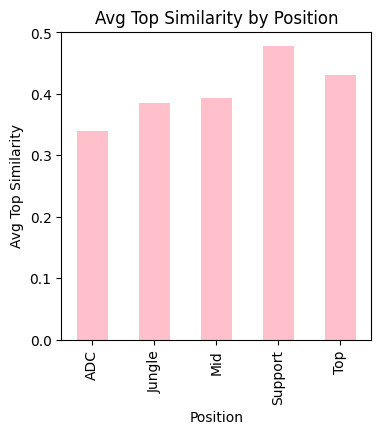

In [92]:
# Bar Chart for similarity by position

# calculate how many matches were found for each position
position_matches = ex2_results.groupby('Position')['Top Similarity'].mean()

# plot the grouped values on a bar chart
position_matches.plot(kind='bar', stacked=True, figsize=(4,4), color='pink')
# change the title and axes labels
plt.title('Avg Top Similarity by Position')
plt.xlabel('Position')
plt.ylabel('Avg Top Similarity')
plt.show()

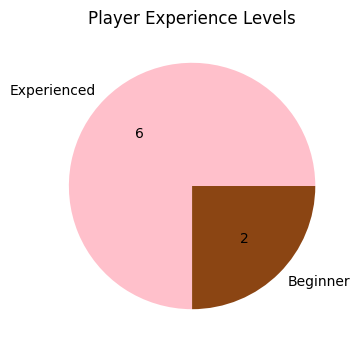

In [121]:
# count number of matches and number with no matches
experience_num = exp2_df['experience'].value_counts()

# plot the pie chart for player experience
plt.figure(figsize=(4,4))
plt.pie(experience_num, labels=experience_num.index, autopct=lambda count: int(round(count *sum(experience for experience in experience_num))/100), colors=['pink', 'saddlebrown'])
plt.title('Player Experience Levels')
plt.show()

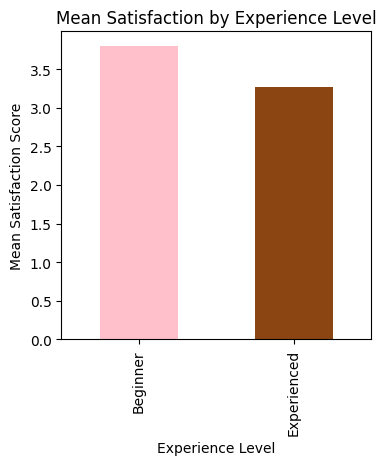

In [115]:
# group data by experience level and calculate mean satisfaction
experience_results = exp2_df.groupby('experience')['Mean_Satisfaction'].mean()

# plot the satisfaction scores by experience level
plt.figure(figsize=(4,4))
experience_results.plot(kind='bar', color=colors)
plt.title('Mean Satisfaction by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Mean Satisfaction Score')

plt.show()

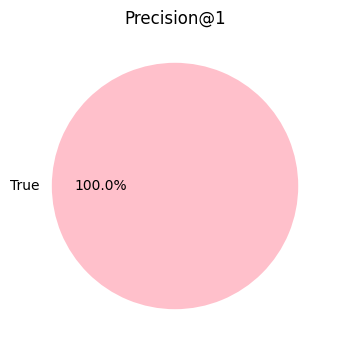

In [122]:
# pie chart demonstrating precision@1
precision_at_1 = exp2_df['P@1_hit'].value_counts()

# plot the pie chart for precision@1
plt.figure(figsize=(4,4))
plt.pie(precision_at_1, labels=precision_at_1.index, autopct='%1.1f%%', colors=['pink', 'saddlebrown'])
plt.title('Precision@1')
plt.show()


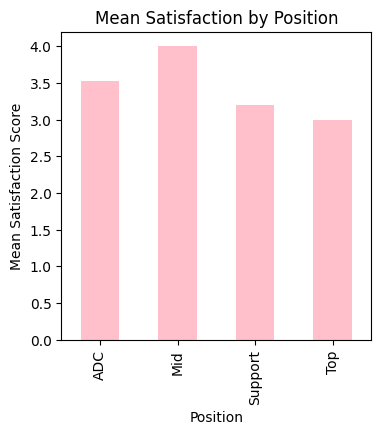

In [129]:
# Bar Chart for mean satisfaction by position

# calculate how many matches were found for each position
position_satisfaction = exp2_df.groupby('Position')['Mean_Satisfaction'].mean()

# plot the grouped values on a bar chart
position_satisfaction.plot(kind='bar', stacked=True, figsize=(4,4), color='pink')
# change the title and axes labels
plt.title('Mean Satisfaction by Position')
plt.xlabel('Position')
plt.ylabel('Mean Satisfaction Score')
plt.show()